# Summary of Analysis

### **Q1: Data Overview and Distribution**
- **Basic Metrics:** Computed basic statistics (mean, median, max, min) to understand the distribution of the data.
- **Outlier Removal:** Cleaned outliers to improve visualization.
- **Visualizations:**
    - Plotted histograms and box plots.
    - **Key Finding:** The histogram showed a right-skewed distribution, indicating that most sites have a small number of visits, while only a few sites attract more traffic. This aligns with the **"80/20 Rule"** where a small number of sites contribute to the majority of visits.

### **Q2: Source Data Distribution**
- **Basic Statistics:** Calculated basic statistics (mean, median, max, min) for each source.
- **Visualizations:**
    - Created histograms, box plots, and CDFs to observe data distributions.
    - **Key Finding:** Scale differences across sources may be due to distinct distributions, different user groups, or varying data collection periods (longer or shorter).

### **Q3: Scaling and Correlation Analysis**
- **Scatter Plot:** Visualized the linear correlation between the visits from each source and the learning set.
- **Scaling Adjustments:** Applied a machine learning model to correct for the scale differences between sources and the learning set.
- **Evaluation Metrics:** Computed RMSE, MAE, MAPE, and MSE to assess model performance and errors.
- **Residuals Plot:** Plotted residuals to inspect the model’s fit.
- **Statistical Test (KS Test)**
### Key Findings:

- **Source 1:**
    - Contains the highest number of overlapping sites with the learning set.
    - Despite the high overlap, it exhibited the lowest R² score, indicating a weaker linear relationship with the learning set.

- **Source 3:**
    - Has the least overlap with the learning set in terms of common sites.
    - Achieved the highest R² score, suggesting a better fit and stronger linear correlation with the learning set.
    - The **KS test** revealed that Source 3's distribution is significantly different from the learning set, highlighting potential differences in underlying data characteristics.

- **Source 2:**
    - Demonstrated the lowest error scores across all evaluation metrics (RMSE, MAE, MAPE, MSE), making it the most reliable source for predictions among the three.


### **Q4: Model Comparison**
- **Ensemble Approach:** Implemented an ensemble learning approach using three models (voting regressor), which did not significantly reduce error compared to individual models.
- **Multiple Sources as Features:** Used all three sources as features in a combined model, which reduced error when compared to Source 2 alone.
- **PCA for Dimensionality Reduction:** Applied PCA to combine the three sources into a single feature, leading to the greatest reduction in error.



In [495]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from sklearn.metrics import auc
from scipy.stats import ks_2samp
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA

pd.set_option('display.float_format', '{:.0f}'.format)


In [496]:
le_set = pd.read_csv('LearningSet.csv', sep='\t')
sources = pd.read_csv('Sources.csv', sep='\t')

In [497]:
# First Question

In [498]:
# Basic Info
print(le_set.info())
print(le_set.describe())
print(le_set.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9699 entries, 0 to 9698
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Site    9699 non-null   object
 1   Visits  9699 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 151.7+ KB
None
         Visits
count      9699
mean     649316
std     5558451
min        5001
25%       14244
50%       41195
75%      173196
max   261974470
Site      0
Visits    0
dtype: int64


In [499]:
# no missing values

In [500]:
# it is hard to see the distribution because the long tail of small amount of sites with very high visits.
# I will trim the tail just so I can have a better look on the distribution

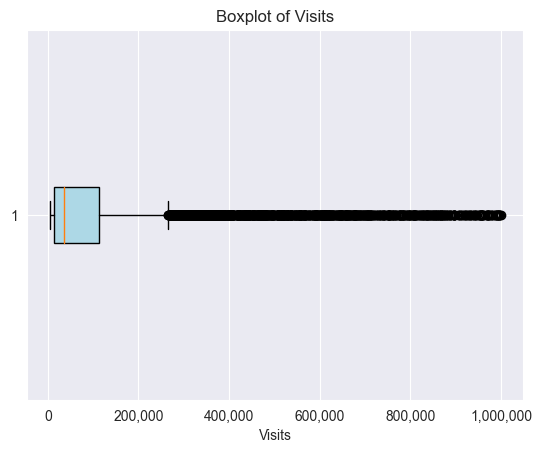

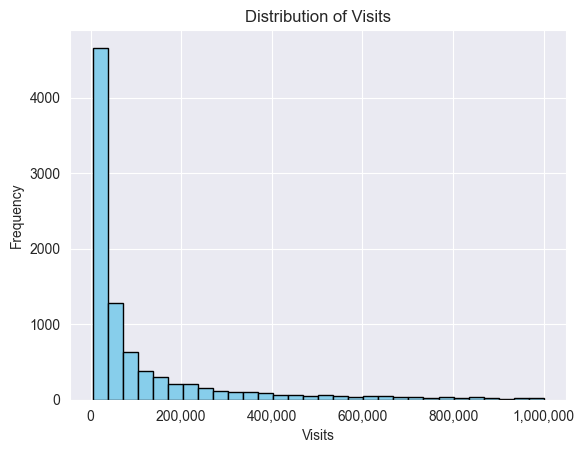

In [501]:
def format_number(x, _):
    return f"{int(x):,}"

filtered_data = le_set[le_set['Visits'] < 1000000]

plt.boxplot(filtered_data['Visits'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_number))
plt.title('Boxplot of Visits')
plt.xlabel('Visits')
plt.show()

plt.hist(filtered_data['Visits'], bins=30, color='skyblue', edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_number))
plt.title('Distribution of Visits')
plt.xlabel('Visits')
plt.ylabel('Frequency')
plt.show()

In [502]:
# the boxplot shows there are few sites with very high visits, could be outliers.
# the Right-Skewed Histogram Distribution shows that there are a lot of sites with small amount of visits, and not as mach sites with high amount of visits.
# This aligns with the "80/20 Rule," where a few top sites drive the bulk of the traffic.
# also the shape of the distribution do not look like a normal distribution.

In [503]:
# Second Question

In [504]:
# Basic Info
print(sources.info())
print(sources.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18652 entries, 0 to 18651
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SourceID  18652 non-null  int64 
 1   Site      18652 non-null  object
 2   Visits    18652 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 437.3+ KB
None
SourceID    0
Site        0
Visits      0
dtype: int64


In [505]:
# no missing values

In [506]:
sources.SourceID.value_counts()

SourceID
1    8502
2    6736
3    3414
Name: count, dtype: int64

In [507]:
# the sourceID is biased regarding number of unique sites in the distribution.

In [508]:
sources.groupby(['SourceID'])['Visits'].sum()

SourceID
1     68477101
2     61029902
3    161395230
Name: Visits, dtype: int64

In [509]:
# sourceid 3 has the highest number of visits and the lowest amount of sites.

In [510]:
print([sources[sources['SourceID'] == x]['Visits'].describe() for x in range(1, 4)])

[count      8502
mean       8054
std       75771
min          10
25%         171
50%         520
75%        2008
max     3713883
Name: Visits, dtype: float64, count      6736
mean       9060
std       44879
min          21
25%         301
50%         949
75%        3541
max     1341459
Name: Visits, dtype: float64, count       3414
mean       47275
std      1201799
min           23
25%          449
50%         1945
75%         7794
max     60908912
Name: Visits, dtype: float64]


In [511]:
# there are differences between the sources in all metrics: count, mean, median and max values.

In [512]:
# the very high visits numbers in source 3 makes it hard to compare the distributions. I will remove the last percentile (could be outlier)

In [513]:
filtered_sources = pd.DataFrame()
for source_id, group in sources.groupby('SourceID'):
    percentile_99 = group['Visits'].quantile(0.99)
    filtered_group = group[group['Visits'] <= percentile_99]
    filtered_sources = pd.concat([filtered_sources, filtered_group], ignore_index=True)

print([filtered_sources[filtered_sources['SourceID'] == x]['Visits'].describe() for x in range(1, 4)])

[count     8416
mean      3656
std      11210
min         10
25%        169
50%        508
75%       1908
max     126972
Name: Visits, dtype: float64, count     6668
mean      5690
std      15662
min         21
25%        299
50%        931
75%       3357
max     159779
Name: Visits, dtype: float64, count     3379
mean     11123
std      28999
min         23
25%        444
50%       1877
75%       7431
max     337983
Name: Visits, dtype: float64]


In [514]:
# let's plot the distributions

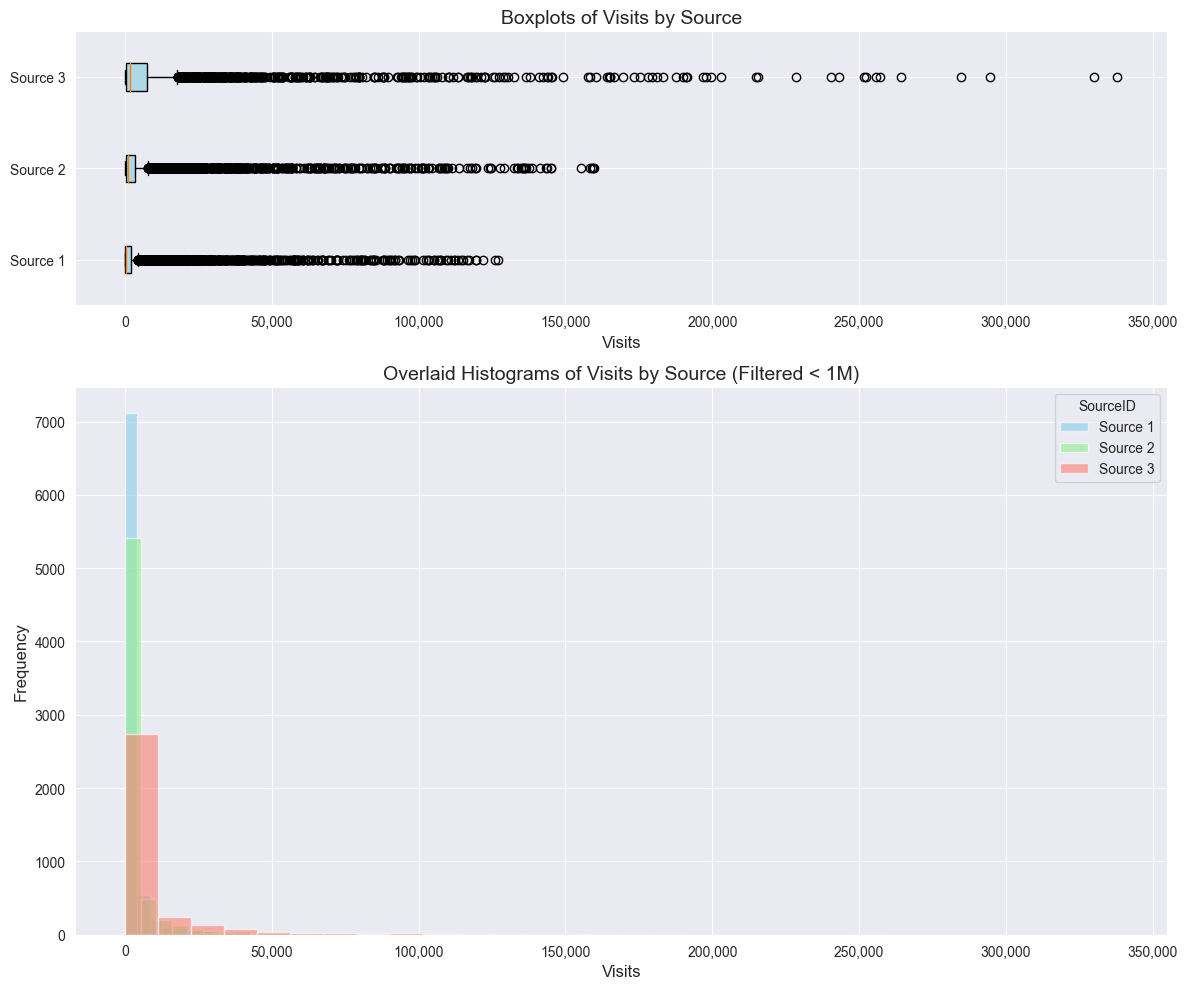

In [515]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2]})

boxplot_data = [filtered_sources[filtered_sources['SourceID'] == ind]['Visits'] for ind in range(1, 4)]

axes[0].boxplot(boxplot_data, vert=False, patch_artist=True,
                boxprops=dict(facecolor="lightblue"),
                labels=[f"Source {i}" for i in range(1, 4)])

axes[0].set_title("Boxplots of Visits by Source", fontsize=14)
axes[0].set_xlabel("Visits", fontsize=12)
axes[0].xaxis.set_major_formatter(FuncFormatter(format_number))

colors = ['skyblue', 'lightgreen', 'salmon']
for ind in range(1, 4):
    plot_data = filtered_sources[filtered_sources['SourceID'] == ind]
    filtered_data = plot_data[plot_data['Visits'] < 1_000_000]
    axes[1].hist(filtered_data['Visits'], bins=30, alpha=0.6,
                 color=colors[ind-1], label=f"Source {ind}")

axes[1].set_title("Overlaid Histograms of Visits by Source (Filtered < 1M)", fontsize=14)
axes[1].set_xlabel("Visits", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].xaxis.set_major_formatter(FuncFormatter(format_number))
axes[1].legend(title="SourceID", loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()


In [516]:
# none of the distributions are shaped like normal distribution. lets add cdfs graphs

AUC of CDF for 1: 607258.3461
AUC of CDF for 2: 617986.4921
AUC of CDF for 3: 544784.9700


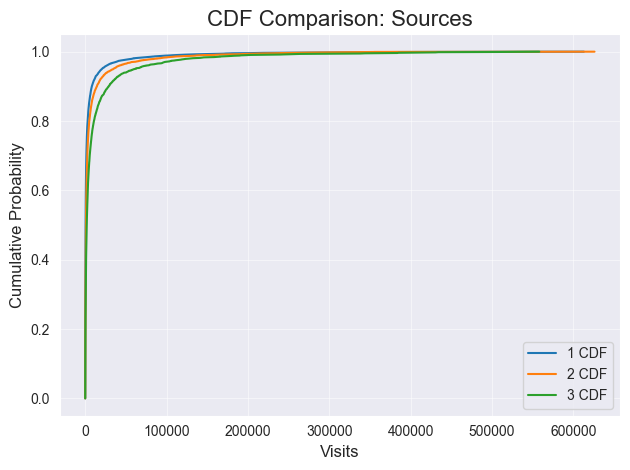

In [517]:
for source_name, group in sources.groupby('SourceID'):
    filtered_sources = group[group['Visits'] <= 625964] # just for visualization
    sorted_visits = np.sort(filtered_sources['Visits'])
    cumulative_probs = np.arange(1, len(sorted_visits) + 1) / len(sorted_visits)
    cdf_auc = auc(sorted_visits, cumulative_probs)
    print(f"AUC of CDF for {source_name}: {cdf_auc:.4f}")
    plt.plot(sorted_visits, cumulative_probs, label=f'{source_name} CDF')

plt.title('CDF Comparison: Sources', fontsize=16)
plt.xlabel('Visits', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [518]:
# The scale may differ because the sources could originate from distinct distributions, represent different groups of people, or reflect varying data collection periods (longer or shorter).

In [519]:
# Third Question

In [520]:
# I want to merge on Site the learning set to the sources set so I can compare between the distributions.
overlap_percentages = {}
for source_id in sources['SourceID'].unique():
    source_sites = set(sources[sources['SourceID'] == source_id]['Site'])
    le_set_sites = set(le_set['Site'])
    overlapping_sites = le_set_sites.intersection(source_sites)
    total_sites_in_leset = len(le_set_sites)
    percentage_overlap = (len(overlapping_sites) / total_sites_in_leset) * 100
    overlap_percentages[source_id] = percentage_overlap
for source_id, overlap in overlap_percentages.items():
    print(f"Source {source_id}: {overlap:.2f}% overlap with learning set")


merged_data = sources.merge(le_set, on='Site', suffixes=('_source', '_le_set'))


Source 1: 87.66% overlap with learning set
Source 2: 69.45% overlap with learning set
Source 3: 35.20% overlap with learning set


In [456]:
# we need to keep in mind the relative size of each source!

In [ ]:
#I will try with some basic visualizations for the relationship between the sources and the learning set.

In [ ]:
# here is a linear fit:

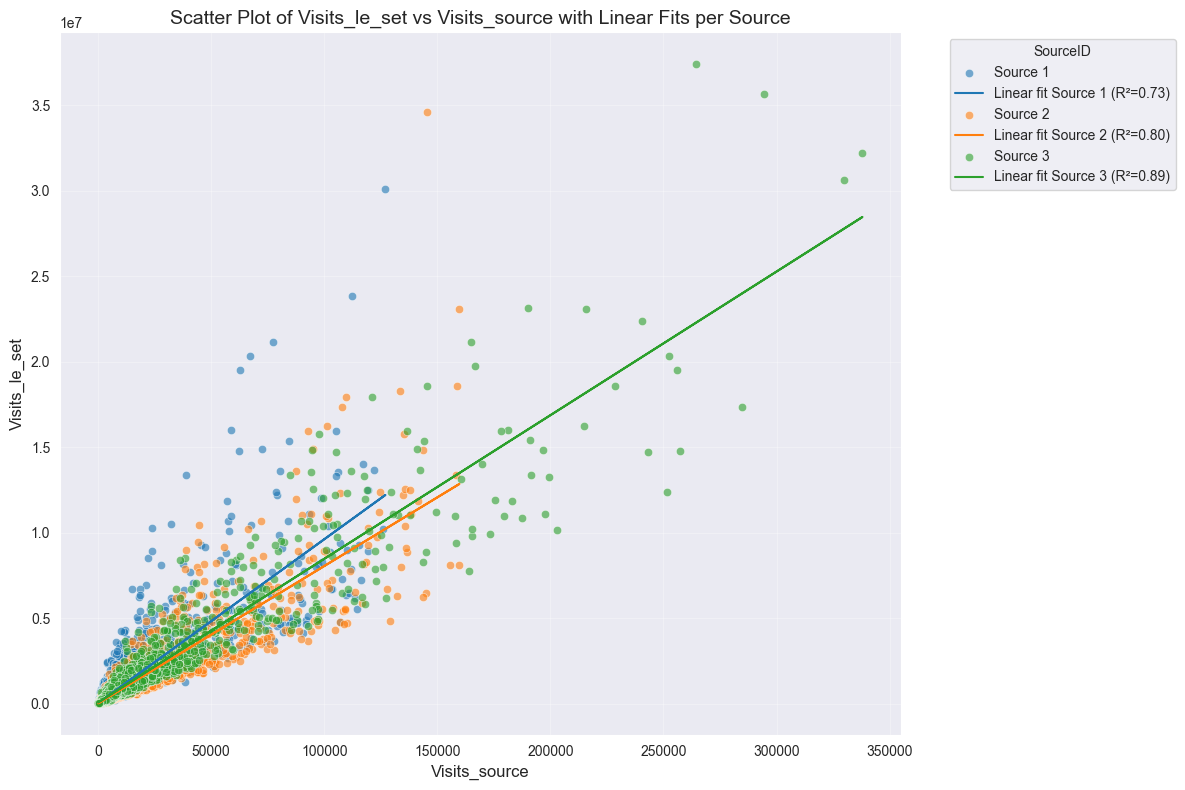

In [521]:
filtered_data = merged_data.copy()

for source_id in filtered_data['SourceID'].unique():
    percentile_99 = filtered_data[filtered_data['SourceID'] == source_id]['Visits_source'].quantile(0.99)
    filtered_data = filtered_data[
        ~((filtered_data['SourceID'] == source_id) & (filtered_data['Visits_source'] > percentile_99))
    ]
plt.figure(figsize=(12, 8))
for source_id in filtered_data['SourceID'].unique():
    source_data = filtered_data[filtered_data['SourceID'] == source_id]

    # Fit the linear regression model
    X = source_data[['Visits_source']]
    y = source_data['Visits_le_set']
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    sns.scatterplot(
        data=source_data,
        x='Visits_source',
        y='Visits_le_set',
        label=f'Source {source_id}',
        alpha=0.6
    )
    plt.plot(source_data['Visits_source'], y_pred, label=f'Linear fit Source {source_id} (R²={r2:.2f})')

plt.title('Scatter Plot of Visits_le_set vs Visits_source with Linear Fits per Source', fontsize=14)
plt.xlabel('Visits_source', fontsize=12)
plt.ylabel('Visits_le_set', fontsize=12)
plt.legend(title='SourceID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [465]:
for source_id in filtered_data['SourceID'].unique():
    source_data = filtered_data[filtered_data['SourceID'] == source_id]
    X = source_data[['Visits_source']]
    y = source_data['Visits_le_set']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    print(f'R² value for Source {source_id}: {r2:.4f}')

R² value for Source 1: 0.7289
R² value for Source 2: 0.7964
R² value for Source 3: 0.8947


In [526]:
# it looks like there is a linear correlation between the sources and the learning set

In [ ]:
# source 3 has the highest r2 score, which means source 3 is the best to explains the variability of the learning set based on the source data itself.

In [ ]:
# # I can use the linear model to scale the sources

In [ ]:
# there are other methods for scaling, like StandardScaler, MinMaxScaler, PowerTransformer and quantile mapping, and it will be interesting to find the best fit, but I will not do this with the time I have

In [ ]:
# now I will use some metrics to measure how good each source can estimate the learning set

In [525]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


metrics = {}
for source_id in filtered_data['SourceID'].unique():
    source_data = filtered_data[filtered_data['SourceID'] == source_id]
    X = source_data[['Visits_source']]
    y = source_data['Visits_le_set']
    model = LinearRegression()
    model.fit(X, y)
    source_data['Visits_source_scaled'] = model.predict(X)
    adjusted_visits = source_data['Visits_source_scaled']
    learning_set_visits = source_data['Visits_le_set']
    source_metrics = {
        'RMSE': rmse(learning_set_visits, adjusted_visits),
        'MAPE': mape(learning_set_visits, adjusted_visits),
        'MAE': mae(learning_set_visits, adjusted_visits),
        'MSE': mse(learning_set_visits, adjusted_visits)    }
    metrics[source_id] = source_metrics
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


    RMSE  MAPE    MAE          MSE
1 654915   127 172440 428913471416
2 636080    54 170559 404597793902
3 835340   149 287837 697793692482


/var/folders/9t/msh0s7lj6nl9lmxf_kw6jlkm0000gn/T/ipykernel_37627/2214588702.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_data['Visits_source_scaled'] = model.predict(X)
/var/folders/9t/msh0s7lj6nl9lmxf_kw6jlkm0000gn/T/ipykernel_37627/2214588702.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_data['Visits_source_scaled'] = model.predict(X)
/var/folders/9t/msh0s7lj6nl9lmxf_kw6jlkm0000gn/T/ipykernel_37627/2214588702.py:21: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [ ]:
# it looks like source 2 has the lowest score at all metrics

In [ ]:
# lets look at the residuals

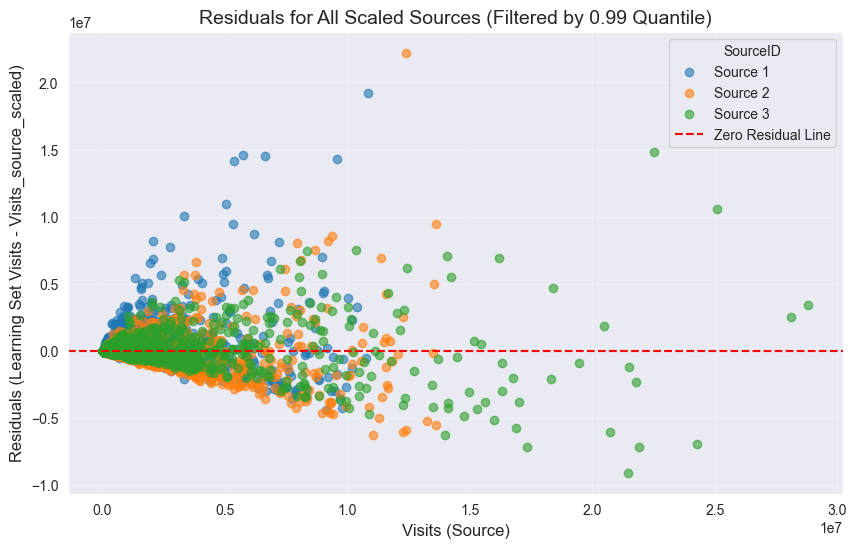

In [530]:
plt.figure(figsize=(10, 6))

for source_id in filtered_data['SourceID'].unique():
    source_data = filtered_data[filtered_data['SourceID'] == source_id]
    visits = source_data['Visits_source_scaled']
    learning_set_visits = source_data['Visits_le_set']
    residuals = learning_set_visits - visits
    plt.scatter(visits, residuals, label=f'Source {source_id}', alpha=0.6)

plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals for All Scaled Sources (Filtered by 0.99 Quantile)', fontsize=14)
plt.xlabel('Visits (Source)', fontsize=12)
plt.ylabel('Residuals (Learning Set Visits - Visits_source_scaled)', fontsize=12)
plt.legend(title='SourceID')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# another way to compare distributions is to use statistical test:

In [ ]:
# Kolmogorov-Smirnov (KS) Test: Tests if two distributions are identical.

In [531]:
ks_results = {}
for source_id in filtered_data['SourceID'].unique():
    source_visits = filtered_data[filtered_data['SourceID'] == source_id]['Visits_source_scaled']
    learning_set_visits = filtered_data[filtered_data['SourceID'] == source_id]['Visits_le_set']

    ks_stat, p_value = ks_2samp(source_visits, learning_set_visits)
    ks_results[source_id] = (ks_stat, p_value)

    print(f"Source {source_id}: KS Statistic = {ks_stat:.4f}, P-Value = {p_value:.4e}")



Source 1: KS Statistic = 0.4102, P-Value = 0.0000e+00
Source 2: KS Statistic = 0.3344, P-Value = 0.0000e+00
Source 3: KS Statistic = 0.2394, P-Value = 2.3571e-85


In [ ]:
# The smaller the KS Statistic, the more similar the two distributions are.
# Hence, we want the source with the lowest statistic. In this case, source 3 has very low p value, which indicates that the comparison is statistically significantly different, even though the KS Statistic itself is moderate.

In [ ]:
# Fourth Question

In [ ]:
# I will try to combine the sources in order to get a better estimator.

In [557]:
# first, I will use Ensemble Learning Approach.
# I will train individual models on each source and combine their predictions to create a more robust final estimator for the learning set.

In [558]:
X = filtered_data[['Visits_source', 'Visits_source_scaled']]
y = filtered_data['Visits_le_set']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {}
for source_id in filtered_data['SourceID'].unique():
    source_data = filtered_data[filtered_data['SourceID'] == source_id]
    X_source = source_data[['Visits_source', 'Visits_source_scaled']]
    y_source = source_data['Visits_le_set']

    X_train_src, X_test_src, y_train_src, y_test_src = train_test_split(
        X_source, y_source, test_size=0.2, random_state=42
    )

    model = XGBRegressor(random_state=42)
    model.fit(X_train_src, y_train_src)

    models[source_id] = model

In [560]:
baseline_predictions = np.zeros(len(X_test))
for source_id, model in models.items():
    baseline_predictions += model.predict(X_test)
baseline_predictions /= len(models)

estimators = [(f'source_{source_id}', model) for source_id, model in models.items()]
voting_regressor = VotingRegressor(estimators=estimators)
voting_regressor.fit(X_train, y_train)

y_pred_ensemble = voting_regressor.predict(X_test)

rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_predictions))
r2_baseline = r2_score(y_test, baseline_predictions)

rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Baseline (Model Average) - RMSE: {rmse_baseline:.4f}, R²: {r2_baseline:.4f}")
print(f"Ensemble Model - RMSE: {rmse_ensemble:.4f}, R²: {r2_ensemble:.4f}")

Baseline (Model Average) - RMSE: 673493.7663, R²: 0.8076
Ensemble Model - RMSE: 684943.6322, R²: 0.8010


In [ ]:
# it looks like the ensemble didnt help. lets try something else:

In [561]:
# reshape the dataframe:
visits_source_pivot = filtered_data.pivot(index='Site', columns='SourceID', values='Visits_source')
visits_source_pivot.columns = [f'Visits_source_{col}' for col in visits_source_pivot.columns]

visits_source_scaled_pivot = filtered_data.pivot(index='Site', columns='SourceID', values='Visits_source_scaled')
visits_source_scaled_pivot.columns = [f'Visits_source_scaled_{col}' for col in visits_source_scaled_pivot.columns]

visits_le_set_pivot = filtered_data.pivot(index='Site', columns='SourceID', values='Visits_le_set')
visits_le_set_pivot.columns = [f'Visits_le_set_{col}' for col in visits_le_set_pivot.columns]

reshaped_data = pd.concat([visits_source_pivot, visits_source_scaled_pivot, visits_le_set_pivot], axis=1)

reshaped_data.reset_index(inplace=True)
reshaped_data_cleaned = reshaped_data.dropna(subset=['Visits_le_set_1'])


In [ ]:
# now I will use all 3 sources as features:

In [562]:
X_multi = reshaped_data_cleaned[['Visits_source_scaled_1', 'Visits_source_scaled_2', 'Visits_source_scaled_3']]
y = reshaped_data_cleaned['Visits_le_set_1']
X_train_multi, X_test_multi, y_train, y_test = train_test_split(X_multi, y, test_size=0.2, random_state=42)

multi_source_model = XGBRegressor(random_state=42)
multi_source_model.fit(X_train_multi, y_train)

y_pred_multi = multi_source_model.predict(X_test_multi)
rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))
r2_multi = r2_score(y_test, y_pred_multi)

source_rmses = {}
source_r2s = {}

for feature in ['Visits_source_scaled_1', 'Visits_source_scaled_2', 'Visits_source_scaled_3']:
    X_single = reshaped_data_cleaned[[feature]]
    X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(
        X_single, y, test_size=0.2, random_state=42
    )
    single_source_model = XGBRegressor(random_state=42)
    single_source_model.fit(X_train_single, y_train_single)

    y_pred_single = single_source_model.predict(X_test_single)
    rmse_single = np.sqrt(mean_squared_error(y_test_single, y_pred_single))
    r2_single = r2_score(y_test_single, y_pred_single)

    source_rmses[feature] = rmse_single
    source_r2s[feature] = r2_single

print("Multi-source Model:")
print(f"RMSE: {rmse_multi:.4f}, R²: {r2_multi:.4f}\n")

print("Single-source Models:")
for feature in source_rmses:
    print(f"{feature}: RMSE = {source_rmses[feature]:.4f}, R² = {source_r2s[feature]:.4f}")


Multi-source Model:
RMSE: 610369.8999, R²: 0.6940

Single-source Models:
Visits_source_scaled_1: RMSE = 541524.8573, R² = 0.7591
Visits_source_scaled_2: RMSE = 677498.5283, R² = 0.6230
Visits_source_scaled_3: RMSE = 468774.6644, R² = 0.8195


In [ ]:
# the multi-source model only did better that source 2 alone. lets try another method.

In [ ]:
# I will use pca to combine the three sources into a unified representation. although i have to make some robust dropna.

In [567]:
reshaped_data_cleaned_2 = reshaped_data_cleaned.dropna()
X_raw = reshaped_data_cleaned_2[['Visits_source_scaled_1', 'Visits_source_scaled_2', 'Visits_source_scaled_3']]
y = reshaped_data_cleaned_2['Visits_le_set_1']

pca = PCA(n_components=1)
reshaped_data_cleaned_2['PCA_feature'] = pca.fit_transform(X_raw)

X = reshaped_data_cleaned_2[['PCA_feature']]
y = reshaped_data_cleaned_2['Visits_le_set_1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pca = XGBRegressor(random_state=42)
model_pca.fit(X_train, y_train)

y_pred_pca = model_pca.predict(X_test)
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
print(f"RMSE for PCA-based model: {rmse_pca:.4f}")

/var/folders/9t/msh0s7lj6nl9lmxf_kw6jlkm0000gn/T/ipykernel_37627/4203503930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reshaped_data_cleaned_2['PCA_feature'] = pca.fit_transform(X_raw)


RMSE for PCA-based model: 510466.4756


In [568]:
# Model using only 'Visits_source_scaled_1'
X1 = reshaped_data_cleaned_2[['Visits_source_scaled_1']]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=42)
model_1 = XGBRegressor(random_state=42)
model_1.fit(X_train1, y_train1)
y_pred_1 = model_1.predict(X_test1)
rmse_1 = np.sqrt(mean_squared_error(y_test1, y_pred_1))
print(f"RMSE for model using Visits_source_scaled_1: {rmse_1:.4f}")

# Model using only 'Visits_source_scaled_2'
X2 = reshaped_data_cleaned_2[['Visits_source_scaled_2']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)
model_2 = XGBRegressor(random_state=42)
model_2.fit(X_train2, y_train2)
y_pred_2 = model_2.predict(X_test2)
rmse_2 = np.sqrt(mean_squared_error(y_test2, y_pred_2))
print(f"RMSE for model using Visits_source_scaled_2: {rmse_2:.4f}")

# Model using only 'Visits_source_scaled_3'
X3 = reshaped_data_cleaned_2[['Visits_source_scaled_3']]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.2, random_state=42)
model_3 = XGBRegressor(random_state=42)
model_3.fit(X_train3, y_train3)
y_pred_3 = model_3.predict(X_test3)
rmse_3 = np.sqrt(mean_squared_error(y_test3, y_pred_3))
print(f"RMSE for model using Visits_source_scaled_3: {rmse_3:.4f}")

RMSE for model using Visits_source_scaled_1: 811346.4059
RMSE for model using Visits_source_scaled_2: 695047.0648
RMSE for model using Visits_source_scaled_3: 549590.2494


In [ ]:
# it looks like the pca reduced the rmse most!

In [ ]:
# more ideas:
# Derive weights proportional to similarity scores (cdf auc, ks test, similarity score)